# MIS: Clase Complementaria 6 (2023-20)

In [1]:
# Cargue de Paquetes
import numpy as np
import pandas as pd
import networkx as nx
import itertools as it
import time
import matplotlib.pyplot as plt
import graph_tools
import random
#import scipy.linalg as linalg 
#py -m pip install scipy==1.8.1

### Función de Generación de Recompensas

In [2]:
# Se genera la función de recompensas
# List_Distributions tiene dentro la información de cada uno de los brazos del bandido multibrazo con len(List_Distributions) brazos
# Reps es la cantidad de veces que se jugará el bandido multibrazo
 
def Generador_Recompensas(List_Distributions:list,reps:int):
    Recompensas = {}
    contador = 0
    for i in List_Distributions:
        if "Bernoulli" in i:
            p = float(i.replace("Bernoulli","").replace("(","").replace(")",""))
            Recompensas[contador] = [np.random.binomial(1,p) for j in range(reps)]
        elif "Binomial" in i:
            n,p = i.replace("Binomial","").replace("(","").replace(")","").split(",")
            Recompensas[contador] =  [np.random.binomial(n,p) for j in range(reps)]
        elif "Uniform" in i:
            a,b = i.replace("Normal","").replace("(","").replace(")","").split(",")
            Recompensas[contador] =  [np.random.uniform(low=a,high=b) for j in range(reps)]
        elif "Normal" in i:
            mu,sigma=i.replace("Normal","").replace("(","").replace(")","").split(",")
            Recompensas[contador] =  [np.random.normal(loc=mu,scale=sigma) for j in range(reps)]
        else:
            raise Exception("Introduzca una distribución válida.")
        contador += 1
    return Recompensas


# Más adelante se generarán las simulaciones. Por ahora nos concentraremos en armar los otros componentes de la práctica de hoy.
# Además, las distribuciones anteriores son generales, pero nos centraremos en la Bernoulli

### Bandidos tipo Bernoulli

In [3]:
# Inicializador de los estimadores Plug-In Q y de Priors de tipo Beta(\alpha,\beta)
# Para Plug-In tipo Q se introducen listas de números. Para Priors tipo Beta se introducen listas de listas de 2 componentes

def Inicializador_Input_Optimizacion(List_Distributions:list,List_Parameters:list,tipo:str):
    l_dist = len(List_Distributions)
    l_param = len(List_Parameters)
    for parameter in List_Parameters:
        if tipo=="Q":
            if isinstance(parameter,(float,int))==False:
                raise Exception("Existen parámetros que no corresponden con su elección de tipo Q")
        elif tipo=="Beta":
            if (isinstance(parameter,(list))==False) or (len(parameter)!=2):
                raise Exception("Existen parámetros que no corresponden con su elección de tipo Beta")
            else:
                if any([((isinstance(k,(int,float))==False) or (k<=0)) for k in parameter]):
                    raise Exception("Parametros inválidos para la distribución Beta")
        else:
            raise Exception('Introduzca un tipo de inicialización válida')
    if l_dist==l_param:
        return List_Parameters
    elif l_param==1:
        return List_Parameters*l_dist
    else:
        raise Exception("Introduzca una listado de parámetros válidos. La lista que introdujo no puede ser procesada")

In [4]:
# Se crea la función de ArgMax necesaria en los modelos Greedy y Epsilon-Greedy

def Optimizador_Arg_Max(List_Expected_Values:list,tipo:str="Q"):
    if len(List_Expected_Values)==0:
        raise Exception("Introduzca una lista no vacía")
    if (isinstance(tipo,(str))==False) or (tipo not in ['Q',"Beta"]):
        raise Exception("Introduzca un tipo válido")
    
    index = [0]
    l = len(List_Expected_Values)
    contador = 0
    if tipo=="Q":
        max = List_Expected_Values[0]
    elif tipo=="Beta":
        alpha,beta = List_Expected_Values[contador]
        max = alpha/(alpha+beta)
    
    while contador<l:

        if tipo=="Q":
            evaluado = List_Expected_Values[contador]
        elif tipo=="Beta":
            alpha,beta = List_Expected_Values[contador]
            evaluado = alpha/(alpha+beta)

        if evaluado>=max:
            if evaluado==max:
                index.append(contador)
            else:
                max=evaluado
                index = [contador]
        contador+=1
    return random.choice(index)

In [5]:
# Se crea la función de selección aleatoria de brazos (K el número de brazos). Se usa distribución uniforme

def Selector_Aleatorio_Brazos(K:int):
    return random.randint(0,K-1)

In [6]:
# Se crea la función de "lanzar la moneda" para explorar/explotar

def Explore_Exploit(epsilon:float):
    return np.random.binomial(1,epsilon)

In [7]:
# Se crea la función que permite ver la realización de la recompensa

def Realizacion_Recompensa(Recompensas:dict,time:int,choice:int):
    return Recompensas[choice][time]

In [8]:
# Se crea la función de sampleo de TS

def Sampling(List_Parameters):
    Sample = []
    for i in List_Parameters:
        alpha,beta=i
        Sample.append(np.random.beta(alpha,beta))
    return Sample

In [9]:
# Actualización de las Q's y parámetros de las Betas según sea el caso

def Actualizador(List_Parameters:list,reward:float,argmax:int,tipo:str,selected:list=[0]):
    if tipo=="Q":
        if len(selected)!=len(List_Parameters):
            raise Exception("El record de elecciones de acciones está mal")
        else:
            Q_present = List_Parameters[argmax]
            if selected[argmax] == 0:
                Q_new = 1
            else:
                Q_new = Q_present+(1/selected[argmax])*(reward-Q_present)
            List_Parameters[argmax] = Q_new
            selected[argmax] += 1
    elif tipo=="Beta":
        alpha_present,beta_present=List_Parameters[argmax]
        List_Parameters[argmax] = [alpha_present+reward,beta_present+1-reward]
    return List_Parameters,selected

### Modelos de aprendizaje

#### Modelos de tipo Q (Básicos)

In [10]:
# QGreedy
def QGreedy(Recompensas,Priors_t_0):
    acciones = []
    pagos = []
    K = len(Recompensas)
    T = len(Recompensas[0])
    t=0
    # Selected (número de veces que se ha seleccionado una acción)
    selected = [0]*K 
    # Estimación del modelo
    Q = Priors_t_0
    while t<T:
        # Elección de la acción
        choice = Optimizador_Arg_Max(Q,"Q")
        # Realización de la recompensa
        reward = Realizacion_Recompensa(Recompensas=Recompensas,time=t,choice=choice)
        # Guardado de las cosas relevantes
        acciones.append(choice)
        pagos.append(reward)
        # Recálculo del modelo
        Q,selected = Actualizador(List_Parameters=Q,reward=reward,argmax=choice,tipo="Q",selected=selected)
        print(choice,reward)
        # Paso siguiente
        t+=1
        
    acciones = np.array(acciones)
    pagos = np.array(pagos)
    
    return [acciones,pagos]   


In [11]:
# QEpsilonGreedy
def QEpsilonGreedy(Recompensas,Priors_t_0,epsilon):
    if (isinstance(epsilon,(float))==False) or (0<=epsilon<=1)==False:
        raise Exception('Introduzca epsilon válido')
    
    acciones = []
    pagos = []
    K = len(Recompensas)
    T = len(Recompensas[0])
    t=0
    # Selected (número de veces que se ha seleccionado una acción)
    selected = [0]*K 
    # Estimación del modelo
    Q = Priors_t_0
    while t<T:
        # Elección de la acción
        if Explore_Exploit(epsilon=epsilon) == 1:
            choice = Selector_Aleatorio_Brazos(K=K)
        else:
            choice = Optimizador_Arg_Max(Q,"Q")
        # Realización de la recompensa
        reward = Realizacion_Recompensa(Recompensas=Recompensas,time=t,choice=choice)
        # Guardado de las cosas relevantes
        acciones.append(choice)
        pagos.append(reward)
        # Recálculo del modelo
        Q,selected = Actualizador(List_Parameters=Q,reward=reward,argmax=choice,tipo="Q",selected=selected)
        print(choice,reward)
        # Paso siguiente
        t+=1
    
    acciones = np.array(acciones)
    pagos = np.array(pagos)

    return [acciones,pagos] 

#### Modelos de tipo Bayesiano con distribuciones Beta y uso de medias

In [12]:
# BetaGreedy
def BetaGreedy(Recompensas,Priors_t_0):
    acciones = []
    pagos = []
    T = len(Recompensas[0])
    t=0
    # Estimación del modelo
    Parameters = Priors_t_0
    while t<T:
        # Elección de la acción
        choice = Optimizador_Arg_Max(Parameters,"Beta")
        # Realización de la recompensa
        reward = Realizacion_Recompensa(Recompensas=Recompensas,time=t,choice=choice)
        # Guardado de las cosas relevantes
        acciones.append(choice)
        pagos.append(reward)
        # Recálculo del modelo
        Parameters,selected = Actualizador(List_Parameters=Parameters,reward=reward,argmax=choice,tipo="Beta")
        print(choice,reward)
        # Paso siguiente
        t+=1

    acciones = np.array(acciones)
    pagos = np.array(pagos)

    return [acciones,pagos]  

In [13]:
# BetaEpsilonGreedy
def BetaEpsilonGreedy(Recompensas,Priors_t_0,epsilon):
    if (isinstance(epsilon,(float))==False) or (0<=epsilon<=1)==False:
        raise Exception('Introduzca epsilon válido')
    
    acciones = []
    pagos = []
    K = len(Recompensas)
    T = len(Recompensas[0])
    t=0
    # Estimación del modelo
    Parameters = Priors_t_0
    while t<T:
        # Elección de la acción
        if Explore_Exploit(epsilon=epsilon) == 1:
            choice = Selector_Aleatorio_Brazos(K=K)
        else:
            choice = Optimizador_Arg_Max(Parameters,"Beta")
        # Realización de la recompensa
        reward = Realizacion_Recompensa(Recompensas=Recompensas,time=t,choice=choice)
        # Guardado de las cosas relevantes
        acciones.append(choice)
        pagos.append(reward)
        # Recálculo del modelo
        Parameters,selected = Actualizador(List_Parameters=Parameters,reward=reward,argmax=choice,tipo="Beta")
        print(choice,reward)
        # Paso siguiente
        t+=1
    acciones = np.array(acciones)
    pagos = np.array(pagos)
    
    return [acciones,pagos]


#### Modelo de tipo bayesiano con distribuciones Beta y Thompson Sampling 

In [14]:
# Modelo de tipo bayesiano con distribuciones Beta y Thompson Sampling 
def BetaTS(Recompensas,Priors_t_0):
    acciones = []
    pagos = []
    T = len(Recompensas[0])
    t=0
    # Estimación del modelo
    Parameters = Priors_t_0
    while t<T:
        # Sampleo
        Sampleo = Sampling(List_Parameters = Parameters)
        # Elección de la acción
        choice = Optimizador_Arg_Max(Sampleo)
        # Realización de la recompensa
        reward = Realizacion_Recompensa(Recompensas=Recompensas,time=t,choice=choice)
        # Guardado de las cosas relevantes
        acciones.append(choice)
        pagos.append(reward)
        # Recálculo del modelo
        Parameters,selected = Actualizador(List_Parameters=Parameters,reward=reward,argmax=choice,tipo="Beta")
        print(choice,reward)
        # Paso siguiente
        t+=1

    acciones = np.array(acciones)
    pagos = np.array(pagos)

    return [acciones,pagos]

# Ojo, no tiene sentido proponer un Thompson Sampling Greedy y Epsilon Greedy, pues precisamente el sampling es lo que permite la exploración.

#### Simulador

In [19]:
# Algunos parámetros por defecto para comprender el funcionamiento del código

# Durante este ejercicio se usará el siguiente bandido:
Bandido = ['Bernoulli({})'.format(i) for i in [0.01*j for j in range(1,6)]]

# Las repeticiones o número de veces a usar el bandido será por defecto n_reps = 2000

# El número de simulaciones será por defecto n_sims = 100

# El listado de epsilon a tratar será:
epsilon = [0.1,0.3,0.5]

In [20]:
# Observen las distribuciones a utilizar:
#Bandido

In [21]:
# Se creará una función que permita inicializar todo el modelo cada vez que se vaya a correr una simulación

def Initialize_Simulation(Bandido,n_reps):
    # Recompensas
    Recompensas = Generador_Recompensas(List_Distributions = Bandido,reps = n_reps)

    # Posición del brazo más beneficioso
    Brazo_Optimo = np.argmax(np.array([float(i.replace('Bernoulli(','').replace(')','')) for i in Bandido]))

    return Recompensas,Brazo_Optimo

In [22]:
def Simulador(epsilon:list=epsilon,n_sims:int=100,n_reps:int=2000,Bandido:list=Bandido):
    #---------------------------------------------------------
    # Parámetros:
    redondeo = 2
    
    #---------------------------------------------------------
    # Se montan los priors:

    # Priors en t_0 para tipo Q (todos inicializados en cero)
    Priors_t_0_Q = Inicializador_Input_Optimizacion(List_Distributions = Bandido,List_Parameters = [0],tipo = "Q")

    # Priors en t_0 para tipo Beta (todos inicializados con parámetros (\alpha,\beta)=(0,0), i.e. en uniformes(0,1))
    Priors_t_0_Beta = Inicializador_Input_Optimizacion(List_Distributions = Bandido,List_Parameters = [[1,1]],tipo = "Beta")

    #---------------------------------------------------------
    # Se monta la simulación:

    simul = 0
    Info_Simulaciones = {}

    while simul<n_sims:

        Recompensas,Brazo_Optimo = Initialize_Simulation(Bandido,n_reps)
        Info_Simulacion = {}

        # Se genera la simulación greedy de cada metodología
        Info_Simulacion['(0)Q'] = QGreedy(Recompensas,Priors_t_0_Q)
        Info_Simulacion['(0)B'] = BetaGreedy(Recompensas,Priors_t_0_Beta)
        # Se genera la simulación de TS usando Betas
        Info_Simulacion['TS'] = BetaTS(Recompensas=Recompensas,Priors_t_0=Priors_t_0_Beta)
        # Se generan las metodologías epsilon greedy para cada epsilon
        for e in epsilon:
            mark = round(e,redondeo)
            Info_Simulacion['({})Q'.format(mark)] = QEpsilonGreedy(Recompensas,Priors_t_0_Q,e)
            Info_Simulacion['({})B'.format(mark)] = BetaEpsilonGreedy(Recompensas,Priors_t_0_Beta,e)
        # Se guarda únicamente los desvíos de la acción óptima
        for modelo in Info_Simulacion:
            perc = Info_Simulacion[modelo][0]==Brazo_Optimo
            Info_Simulacion[modelo][0] = perc


        # Se guardan los datos relevantes de la simulación
        Info_Simulaciones[simul] = Info_Simulacion
        print("-"*10,"(",simul,")","-"*10)
        simul+=1
    
    # Se retornan los datos de las simulaciones
    return Info_Simulaciones
    
    


### Simulación

In [23]:
# Prueben las siguientes (ejemplos suaves computacionalmente):
#Simulaciones = Simulador()
thetas = [0.1,0.05,0.15]
Bandit = ['Bernoulli({})'.format(i) for i in thetas]
Simulaciones = Simulador(n_reps=10)

0 0
0 0
1 0
1 0
0 0
2 0
2 0
1 0
3 0
3 0
1 0
4 0
0 0
3 0
2 0
0 0
4 0
2 0
1 0
3 0
2 0
3 0
4 0
0 0
1 0
3 0
4 0
0 0
3 0
2 0
3 0
3 0
2 0
2 0
4 0
1 0
1 0
4 0
1 0
0 0
1 0
2 0
0 0
1 0
4 0
3 0
4 0
1 0
0 0
2 0
0 0
0 0
0 0
1 0
1 0
4 0
4 0
3 0
3 0
0 0
3 0
4 0
0 0
1 0
3 1
4 0
3 0
3 0
3 0
3 0
3 0
2 0
2 0
3 0
0 0
2 0
0 0
1 0
1 0
3 0
0 0
3 0
2 0
1 0
3 1
1 0
3 0
3 0
3 0
0 0
---------- ( 0 ) ----------
0 0
0 0
0 0
1 0
1 0
0 0
3 0
3 0
3 0
0 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
2 0
3 1
4 0
3 0
2 0
3 0
4 0
1 0
3 0
0 0
2 0
4 0
3 0
2 0
1 0
2 0
1 0
3 0
0 0
0 0
0 0
0 0
3 0
3 0
3 0
3 0
3 0
3 0
4 0
3 0
3 0
3 1
0 0
0 0
2 0
2 0
4 0
4 0
0 0
4 0
2 0
2 0
3 0
3 0
3 0
3 0
1 0
3 0
3 0
4 0
2 0
3 1
0 0
4 0
1 0
0 0
4 0
1 0
1 0
3 0
1 0
3 1
3 0
4 0
3 0
3 0
3 0
2 0
1 0
3 0
0 0
0 0
---------- ( 1 ) ----------
3 0
3 0
3 0
3 0
0 0
0 0
0 0
1 1
1 0
0 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
4 0
2 1
2 0
3 0
0 0
0 0
2 0
2 0
2 0
3 0
4 0
4 0
2 0
3 0
3 0
0 0
0 0
2 0
4 0
0 0
2 0
0 0
2 0
2 0
2 0
3 0
3 0
2 0
4 0
4 0
2 0
2 1
2 0
2 0


In [24]:
# Prueben el siguientes (ejemplos más pesado computacionalmente, tengan cuidado con los parámetros que le ponen):
#Bandido = ['Bernoulli({})'.format(np.random.beta(1,1)) for i in range(2000)]
#Simulaciones = Simulador(n_sims=100,n_reps=100,Bandido=Bandido)
# Tiempo estimado 1min 14 sec (pero puede escalar rápidamente)

#### Generación de Tablas

In [25]:
# Se genera una tabla por variable relevante. En este caso, se tienen tres: retornos promedio por 
# metodología en cada jugada, retorno acumulado hasta cierto punto y proxi de probabilidad de elegir el brazo óptimo.

# Primero, se extraen los nombres de las metodologías y el recorrido a realizar sobre las simulaciones:
Names = Simulaciones[0].keys()
Recorrido = Simulaciones.keys()
n_sim = len(Recorrido)

# Se crean las tablas:
Probabilidades = pd.DataFrame()
Retornos = pd.DataFrame()
Acumulados = pd.DataFrame()

# Ahora se crean las variables relevantes
for variable in Names:
    P = pd.DataFrame()
    Ret = pd.DataFrame()
    Cum = pd.DataFrame()
    for sim in Recorrido:
        P[sim] = Simulaciones[sim][variable][0]
        Ret[sim] = Simulaciones[sim][variable][1]
        Cum[sim] = Ret[sim].cumsum()

    Probabilidades[variable] = P.mean(axis=1)
    Retornos[variable] = Ret.mean(axis=1)
    Acumulados[variable] = Cum.mean(axis=1)

# Se eliminan cosas que ocupan memoria de forma innecesaria
#del Simulaciones

<AxesSubplot:>

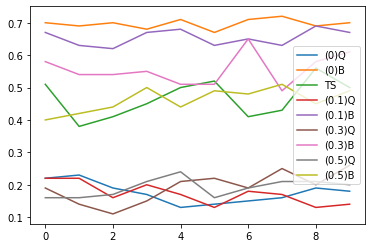

In [26]:
# Se grafican las variables relevantes (Probabilidades de quedar en el brazo óptimo):
Probabilidades.plot()

<AxesSubplot:>

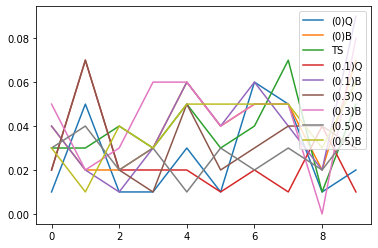

In [27]:
# Se grafican las variables relevantes (Retorno promedio por jugada):
Retornos.plot()

<AxesSubplot:>

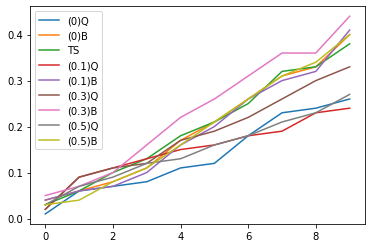

In [28]:
# Se grafican las variables relevantes (Retorno acumulado promedio):
Acumulados.plot()